**Module Path**

In [1]:
import os

os.chdir("./../..")

# Discretization

---

In this notebook, we will deal with continuous state and action spaces by discretizing them. This will enable us to apply reinforcement learning algorithms that are only designed to work with discrete spaces.

### 1. Import the Necessary Packages

In [2]:
import numpy as np
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()

import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use("ggplot")
np.set_printoptions(precision=3, linewidth=120)

is_ipython = "inline" in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

### 2. Specify the Environment, and Explore the State and Action Spaces

We'll use [OpenAI Gym](https://gym.openai.com/) environments to test and develop our algorithms. These simulate a variety of classic as well as contemporary reinforcement learning tasks.  Let's use an environment that has a continuous state space, but a discrete action space.

In [3]:
from env import Gym
from policy import RandomPolicy

env = Gym("mountaincar")

Run the next code cell to watch a random agent.

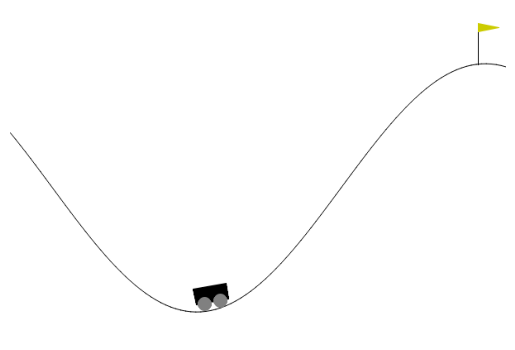

In [4]:
random_policy = RandomPolicy(env.get_action_space())
env.watch(random_policy, display, steps=100)

We will train an agent to perform much better than random one above! First, let's explore the state and action spaces, as well as sample them.

In [5]:
# Explore state (observation) space
print("State space:", env.get_observation_space())
print("- low:", env.get_observation_space().low)
print("- high:", env.get_observation_space().high)

State space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
- low: [-1.2  -0.07]
- high: [0.6  0.07]


In [6]:
# Generate some samples from the state space
print("State space samples:")
print(np.array([env.get_observation_space().sample() for i in range(10)]))

State space samples:
[[-0.103 -0.029]
 [ 0.103 -0.046]
 [ 0.262  0.033]
 [-0.65   0.061]
 [-0.906 -0.016]
 [ 0.371 -0.006]
 [ 0.003 -0.008]
 [ 0.345  0.02 ]
 [-0.07   0.026]
 [ 0.132 -0.065]]


In [7]:
# Explore the action space
print("Action space:", env.get_action_space())

# Generate some samples from the action space
print("Action space samples:")
print(np.array([env.get_action_space().sample() for i in range(10)]))

Action space: Discrete(3)
Action space samples:
[1 0 2 2 0 1 0 2 0 2]


### 3. Discretize the State Space with a Uniform Grid

We will discretize the space using a uniformly-spaced grid. Let's implement a function to create such a grid, given the lower bounds (`low`), upper bounds (`high`), and number of desired `bins` along each dimension. It will return the split points for each dimension, which will be 1 less than the number of bins.

For instance, if `low = [-1.0, -5.0]`, `high = [1.0, 5.0]`, and `bins = (10, 10)`, then this function will return the following list of 2 NumPy arrays:

```
[array([-0.8, -0.6, -0.4, -0.2,  0.0,  0.2,  0.4,  0.6,  0.8]),
 array([-4.0, -3.0, -2.0, -1.0,  0.0,  1.0,  2.0,  3.0,  4.0])]
```

Note that the ends of `low` and `high` are **not** included in these split points. It is assumed that any value below the lowest split point maps to index `0` and any value above the highest split point maps to index `n-1`, where `n` is the number of bins along that dimension.

In [8]:
def create_uniform_grid(low, high, bins=(10, 10)):
    """Define a uniformly-spaced grid that can be used to discretize a space.

    Parameters
    ----------
    low : array_like
        Lower bounds for each dimension of the continuous space.
    high : array_like
        Upper bounds for each dimension of the continuous space.
    bins : tuple
        Number of bins along each corresponding dimension.

    Returns
    -------
    grid : list of array_like
        A list of arrays containing split points for each dimension.
    """
    grid = [np.linspace(low[i], high[i], bins[i] + 1)[1:-1] for i in range(len(bins))]
    return grid


low = [-1.0, -5.0]
high = [1.0, 5.0]
create_uniform_grid(low, high)  # [test]

[array([-0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8]),
 array([-4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.])]

Now we write a function that can convert samples from a continuous space into its equivalent discretized representation, given a grid like the one you created above. You can use the [`numpy.digitize()`](https://docs.scipy.org/doc/numpy-1.9.3/reference/generated/numpy.digitize.html) function for this purpose.

**Note**: There may be one-off differences in binning due to floating-point inaccuracies when samples are close to grid boundaries, but that is alright.

In [9]:
def discretize(sample, grid):
    """Discretize a sample as per given grid.

    Parameters
    ----------
    sample : array_like
        A single sample from the (original) continuous space.
    grid : list of array_like
        A list of arrays containing split points for each dimension.

    Returns
    -------
    discretized_sample : array_like
        A sequence of integers with the same number of dimensions as sample.
    """
    discretized_sample = [np.digitize(sample[i], grid[i]) for i in range(len(sample))]
    return np.array(discretized_sample)


# Test with a simple grid and some samples
grid = create_uniform_grid([-1.0, -5.0], [1.0, 5.0])
samples = np.array(
    [
        [-1.0, -5.0],
        [-0.81, -4.1],
        [-0.8, -4.0],
        [-0.5, 0.0],
        [0.2, -1.9],
        [0.8, 4.0],
        [0.81, 4.1],
        [1.0, 5.0],
    ]
)
discretized_samples = np.array([discretize(sample, grid) for sample in samples])
print("\nSamples:", repr(samples), sep="\n")
print("\nDiscretized samples:", repr(discretized_samples), sep="\n")


Samples:
array([[-1.  , -5.  ],
       [-0.81, -4.1 ],
       [-0.8 , -4.  ],
       [-0.5 ,  0.  ],
       [ 0.2 , -1.9 ],
       [ 0.8 ,  4.  ],
       [ 0.81,  4.1 ],
       [ 1.  ,  5.  ]])

Discretized samples:
array([[0, 0],
       [0, 0],
       [1, 1],
       [2, 5],
       [5, 3],
       [9, 9],
       [9, 9],
       [9, 9]])


### 4. Visualization

Now, we visualize the original and discretized samples to get a sense of how much error we are introducing.

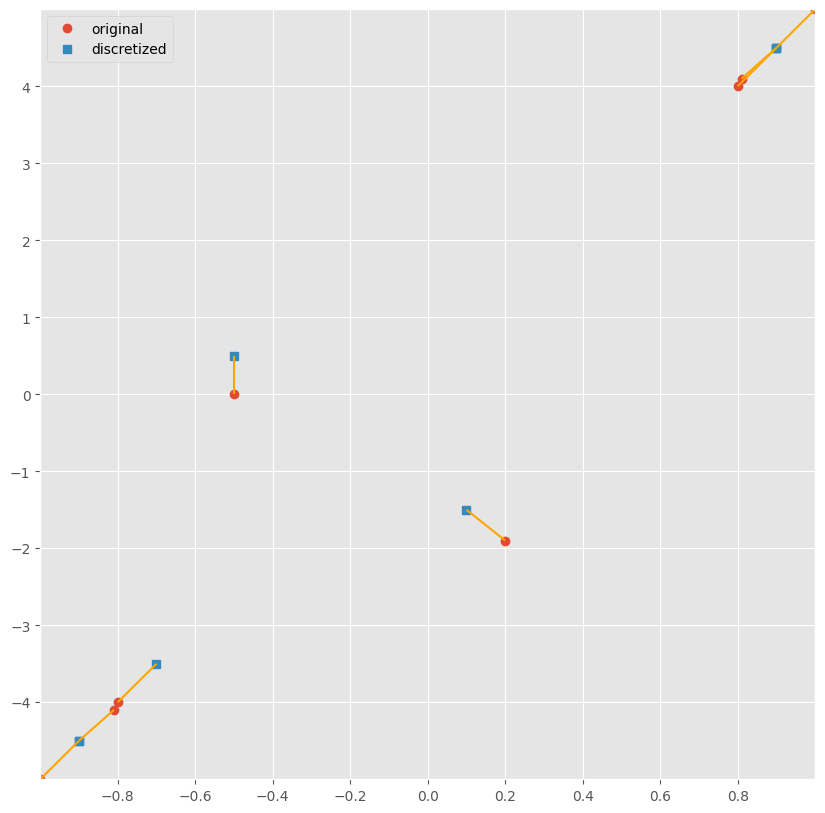

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc


def visualize_samples(samples, discretized_samples, grid, low=None, high=None):
    """Visualize original and discretized samples on a given 2-dimensional grid."""

    fig, ax = plt.subplots(figsize=(10, 10))

    # Show grid
    ax.xaxis.set_major_locator(plt.FixedLocator(grid[0]))
    ax.yaxis.set_major_locator(plt.FixedLocator(grid[1]))
    ax.grid(True)

    # If bounds (low, high) are specified, use them to set axis limits
    if low is not None and high is not None:
        ax.set_xlim(low[0], high[0])
        ax.set_ylim(low[1], high[1])
    else:
        # Otherwise use first, last grid locations as low, high (for further mapping discretized samples)
        low = [splits[0] for splits in grid]
        high = [splits[-1] for splits in grid]

    # Map each discretized sample (which is really an index) to the center of corresponding grid cell
    grid_extended = np.hstack(
        (np.array([low]).T, grid, np.array([high]).T)
    )  # add low and high ends
    grid_centers = (
        grid_extended[:, 1:] + grid_extended[:, :-1]
    ) / 2  # compute center of each grid cell

    # Convert generator expression to a list for np.stack
    locs = np.stack(
        [grid_centers[i, discretized_samples[:, i]] for i in range(len(grid))]
    ).T  # map discretized samples

    ax.plot(samples[:, 0], samples[:, 1], "o")  # plot original samples
    ax.plot(locs[:, 0], locs[:, 1], "s")  # plot discretized samples in mapped locations
    ax.add_collection(
        mc.LineCollection(list(zip(samples, locs)), colors="orange")
    )  # add a line connecting each original-discretized sample
    ax.legend(["original", "discretized"])


# Example usage
visualize_samples(samples, discretized_samples, grid, low, high)

Now that we have a way to discretize a state space, let's apply it to our reinforcement learning environment.

In [11]:
# Create a grid to discretize the state space
state_grid = create_uniform_grid(
    env.get_observation_space().low, env.get_observation_space().high, bins=(10, 10)
)
state_grid

[array([-1.02, -0.84, -0.66, -0.48, -0.3 , -0.12,  0.06,  0.24,  0.42], dtype=float32),
 array([-0.056, -0.042, -0.028, -0.014,  0.   ,  0.014,  0.028,  0.042,  0.056], dtype=float32)]

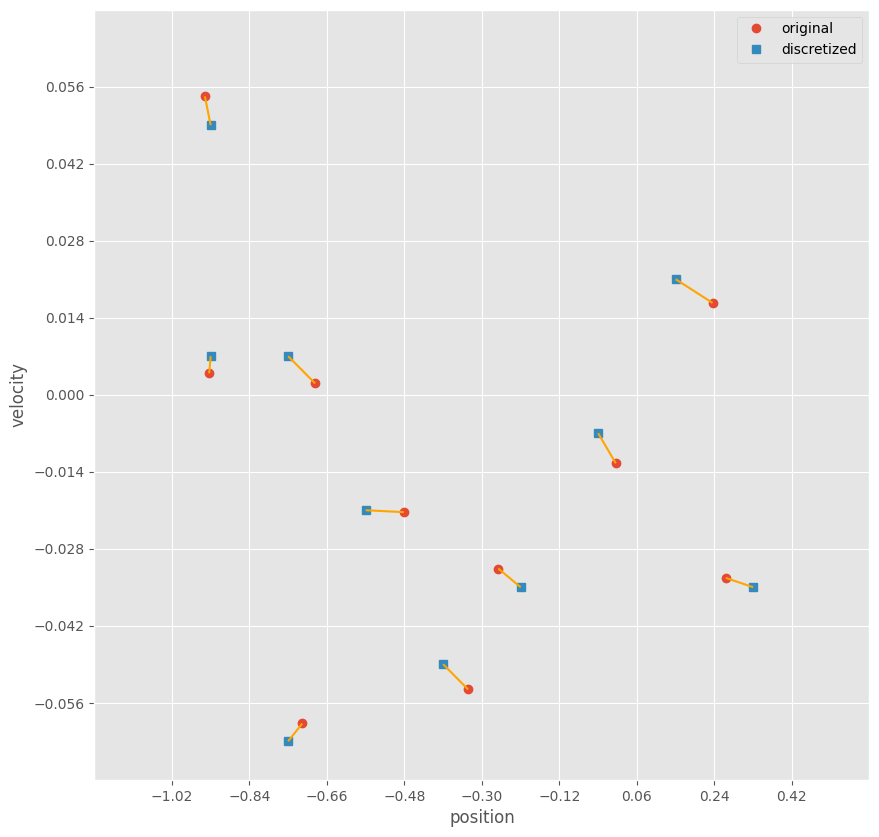

In [12]:
# Obtain some samples from the space, discretize them, and then visualize them
state_samples = np.array([env.get_observation_space().sample() for i in range(10)])
discretized_state_samples = np.array(
    [discretize(sample, state_grid) for sample in state_samples]
)
visualize_samples(
    state_samples,
    discretized_state_samples,
    state_grid,
    env.get_observation_space().low,
    env.get_observation_space().high,
)
plt.xlabel("position")
plt.ylabel("velocity");  # axis labels for MountainCar-v0 state space

We can notice that if we have enough bins, the discretization doesn't introduce too much error into your representation.  So we may be able to now apply a reinforcement learning algorithm (like Q-Learning) that operates on discrete spaces.

### 5. Q-Learning

In [13]:
from policy import DiscretizedSarsaMaxPolicy
from qtable import DictionaryQTable

q_table = DictionaryQTable()
q_table.initialize(env.get_action_space().n)
policy = DiscretizedSarsaMaxPolicy(q_table, env.get_action_space(), state_grid)

In [14]:
from train import TrainerTD

trainer = TrainerTD(policy, env)
trainer.train(50_000)

In [15]:
trainer.evaluate(100)

Evaluation: Average reward over 100 episodes: -100.0


It's also interesting to look at the final Q-table that is learned by the agent. Note that the Q-table is of size MxNxA, where (M, N) is the size of the state space, and A is the size of the action space. We are interested in the maximum Q-value for each state, and the corresponding (best) action associated with that value.

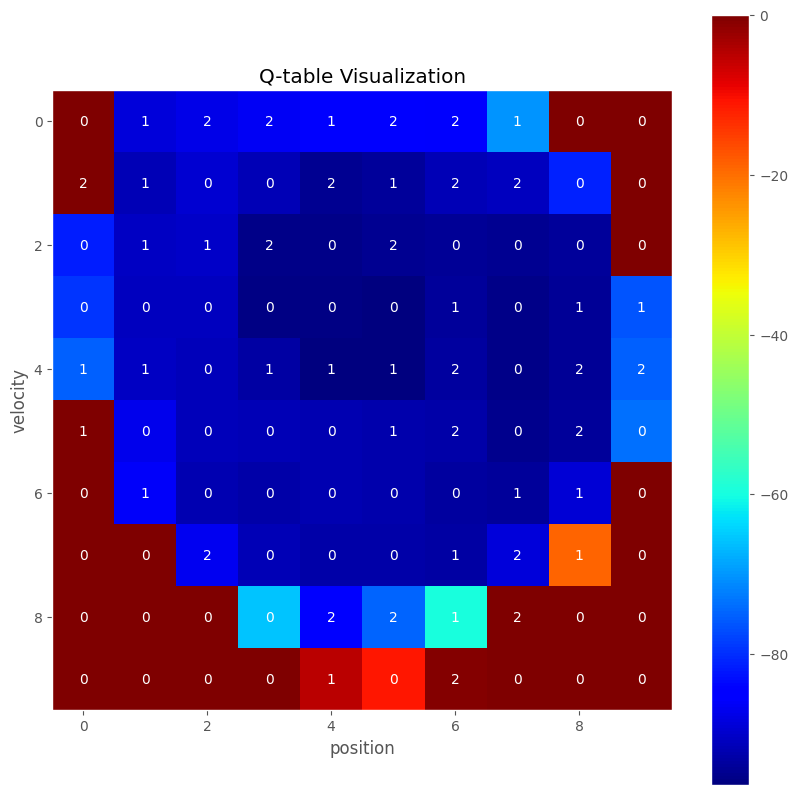

In [16]:
def plot_q_table(q_table, state_grid):
    """Visualize max Q-value for each state and corresponding action using a dictionary-based Q-table."""
    # Extract grid dimensions from state grid
    x_dim, y_dim = len(state_grid[0]) + 1, len(state_grid[1]) + 1
    q_image = np.zeros((x_dim, y_dim))  # grid for max Q-values
    q_actions = np.zeros((x_dim, y_dim), dtype=int)  # grid for actions

    # Populate q_image and q_actions by iterating through states
    for state, q_values in q_table.q_values.items():
        if not isinstance(state, tuple):
            continue
        max_q_value = np.max(q_values)  # max Q-value for this state
        best_action = np.argmax(q_values)  # best action for this state

        # Assuming state is a tuple (discretized position, discretized velocity)
        x, y = state
        q_image[x, y] = max_q_value
        q_actions[x, y] = best_action

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap="jet")
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(
                y,  # Notice (x, y) order, adjusting for imshow's orientation
                x,
                q_actions[x, y],
                color="white",
                horizontalalignment="center",
                verticalalignment="center",
            )
    ax.grid(False)
    ax.set_title("Q-table Visualization")
    ax.set_xlabel("position")
    ax.set_ylabel("velocity")
    plt.show()


plot_q_table(q_table, state_grid)

### 6. Watch a Smart Agent

Score:  -308.0


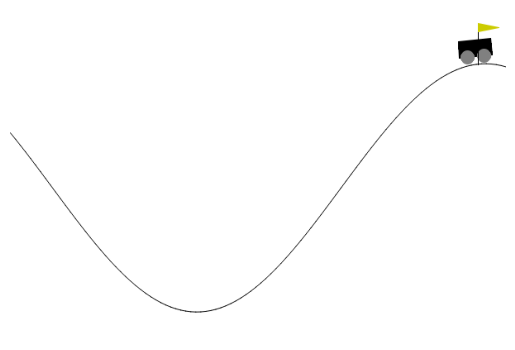

In [17]:
env.watch(policy, display)